In [1]:
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [2]:
labels = pd.read_csv("C:/Users/akabo/Downloads/data challenger/data-new/data-new/labels_obf.csv")
transaction = pd.read_csv("C:/Users/akabo/Downloads/data challenger/data-new/data-new/transactions_obf.csv")

In [708]:
labels.head()

,reportedTime,eventId
0,2017-01-04T00:00:00Z,101536329A1
1,2017-01-04T00:00:00Z,101536425A1
2,2017-01-04T00:00:00Z,101536473A1
3,2017-01-04T00:00:00Z,101536617A1
4,2017-01-04T00:00:00Z,101536761A1


In [709]:
transaction.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.7,7500
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.2,4500
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.0,9500
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.0,7500
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.0,10500


In [710]:
# Firstly we join the data set by eventId
tran=transaction.join(labels.set_index('eventId'), on='eventId')

In [711]:
tran.shape

(118621, 11)

In [712]:
tran.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.7,7500,NaN
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.2,4500,NaN
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.0,9500,NaN
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.0,7500,NaN
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.0,10500,NaN


In [713]:
# lets have a look of the null/nan values in the data set. It seems that we should drop column "merchantZip"
tran.apply(lambda x : x.isnull().sum())

transactionTime           0
eventId                   0
accountNumber             0
merchantId                0
mcc                       0
merchantCountry           0
merchantZip           23005
posEntryMode              0
transactionAmount         0
availableCash             0
reportedTime         117746
dtype: int64

In [714]:
# let's have a look of the transactionAmount, we can see that the min is negative which makes no sense. 
tran.transactionAmount.describe()

count   118621.0
mean        53.7
std        183.7
min         -0.1
25%          8.0
50%         20.2
75%         49.0
max      13348.0
Name: transactionAmount, dtype: float64

In [715]:
# We assign the transactionAmount which is negative as 0 
tran.loc[tran["transactionAmount"]<0,"transactionAmount"] =0

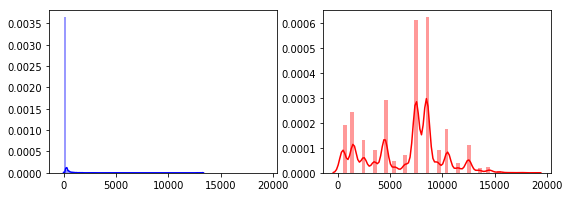

In [716]:
# Try to draw the plot of distrbution of transactionAmount & availableCash
#"transactionAmount" are left skewed, need transformation to a normal distribution for parametric models
import seaborn as sns
f, axes = plt.subplots(1, 2, figsize=(9, 3), sharex=True)
sns.distplot(tran[["transactionAmount"]],color="blue", ax=axes[0])
sns.distplot(tran[["availableCash"]], color="red", ax=axes[1])

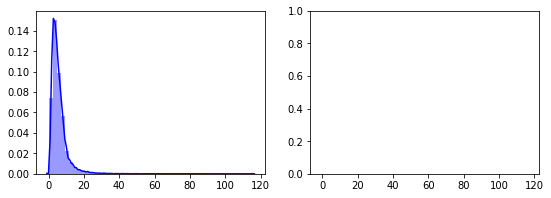

In [717]:
# use sqrt, log too strong
f, axes = plt.subplots(1, 2, figsize=(9, 3), sharex=True)
sns.distplot(np.sqrt(tran[["transactionAmount"]]),color="blue", ax=axes[0])

# Data cleaning

In [718]:
# Here is the data cleaning part. Firstly I will deal with the target vatiable. 1 as Fraud.0 as not fraud
tran1=tran.reportedTime.isnull().astype('category')
tran2 = tran1.replace({True:0, False:1})
tran3 =pd.concat([tran.iloc[:,:10], tran2], axis=1)
tran3.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.7,7500,0
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.2,4500,0
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.0,9500,0
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.0,7500,0
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.0,10500,0


In [719]:
tran2.value_counts()

0    117746
1       875
Name: reportedTime, dtype: int64

In [720]:
# I decided to count the frequency of accountNumber and replace it with the levels since there are too many levels in accountNumber
# # how many times an account number is shared
# because we are studying user's first transaction
# the more an account is shared, the more suspicous
a =tran3.accountNumber.value_counts()
a= pd.DataFrame(a)
a.loc[:,"name"] =a.index
a.head()

,accountNumber,name
66b2f8b3,1312,66b2f8b3
43cbc280,1221,43cbc280
019e6b58,1206,019e6b58
a9024060,1047,a9024060
76676ffc,1008,76676ffc


In [721]:
tran4 =tran3.merge(a, left_on='accountNumber', right_on='name')

In [722]:
# we want to drop merchantId in the future since it's highly correlated to mcc, also with too many individual ids
tran4.merchantId.value_counts().head()

96878e    3294
243074    2281
7f7cdb    1784
4fd0ff    1554
7c3a49    1143
Name: merchantId, dtype: int64

In [723]:
# We drop transactiontime and eventid as they are redundant in the model
tran4.drop(["transactionTime","eventId","accountNumber_x","merchantId"], inplace=True, axis=1)

In [724]:
tran4.head()

,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,accountNumber_y,name
0,5968,826,CR0,1,10.7,7500,0,362,94f9b4e7
1,4816,826,L39LQ,81,274.9,8500,0,362,94f9b4e7
2,4816,826,L39LQ,81,11.0,8500,0,362,94f9b4e7
3,5968,826,UB11,1,8.4,7500,0,362,94f9b4e7
4,5968,826,CR0,1,12.0,8500,0,362,94f9b4e7


In [725]:
# I also calculate the frequency of mcc and assign the category levels with numbers
# how many times a category is shared
c =tran4.mcc.value_counts()
c= pd.DataFrame(c)
c.loc[:,"name"] =c.index
tran5 =tran4.merge(c, left_on='mcc', right_on='name')

In [726]:
tran5.drop(["mcc_x","name_x","name_y"], inplace=True, axis=1)

In [727]:
tran5.head()

,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,accountNumber_y,mcc_y
0,826,CR0,1,10.7,7500,0,362,2219
1,826,UB11,1,8.4,7500,0,362,2219
2,826,CR0,1,12.0,8500,0,362,2219
3,826,TS17,1,25.2,7500,0,362,2219
4,826,UB11,1,8.4,7500,0,362,2219


In [728]:
# As for merchant country, I try to reduce dimensions from 82 to 12, assign "others" to the levels under 100 which is comparitively low in frequency
d =tran5.merchantCountry.value_counts()
d= pd.DataFrame(d)
d.loc[:,"name"] =d.index

In [729]:
country_list = d.loc[d.merchantCountry>180,"name"]

In [730]:
tran5.loc[~tran5["merchantCountry"].isin(country_list),"merchantCountry"]="Others"

In [731]:
tran5.merchantCountry.value_counts()

826       95616
442       14929
840        2873
Others     1713
372        1414
250         483
528         406
724         298
380         247
276         240
292         216
196         186
Name: merchantCountry, dtype: int64

In [732]:
# drop merchantZip as there were too many missing values
tran5.merchantZip.isnull().sum()

23005

# Dummy


In [733]:
# get dummy variable of merchantCountry
tran5.merchantCountry = tran5.merchantCountry.astype("category")
country_dummy= pd.get_dummies(tran5.merchantCountry, prefix='country')
tran6 = pd.concat([tran5, country_dummy],axis=1)


In [734]:
tran6.drop(["merchantCountry","merchantZip"],axis=1).head()

,posEntryMode,transactionAmount,availableCash,reportedTime,accountNumber_y,mcc_y,country_196,country_250,country_276,country_292,country_372,country_380,country_442,country_528,country_724,country_826,country_840,country_Others
0,1,10.7,7500,0,362,2219,0,0,0,0,0,0,0,0,0,1,0,0
1,1,8.4,7500,0,362,2219,0,0,0,0,0,0,0,0,0,1,0,0
2,1,12.0,8500,0,362,2219,0,0,0,0,0,0,0,0,0,1,0,0
3,1,25.2,7500,0,362,2219,0,0,0,0,0,0,0,0,0,1,0,0
4,1,8.4,7500,0,362,2219,0,0,0,0,0,0,0,0,0,1,0,0


In [735]:
# get dummy variable of posEntryMode
tran6.posEntryMode = tran6.posEntryMode.astype("category")
pos_dummy= pd.get_dummies(tran6.posEntryMode, prefix='posEntryMode')
tran7 = pd.concat([tran6, pos_dummy],axis=1)

In [736]:
tran7 =tran7.drop(["merchantCountry","merchantZip",'posEntryMode'],axis=1)

In [737]:
tran7.transactionAmount = np.sqrt(tran7.transactionAmount)

In [738]:
tran7.dtypes

transactionAmount    float64
availableCash          int64
reportedTime           int64
accountNumber_y        int64
mcc_y                  int64
country_196            uint8
country_250            uint8
country_276            uint8
country_292            uint8
country_372            uint8
country_380            uint8
country_442            uint8
country_528            uint8
country_724            uint8
country_826            uint8
country_840            uint8
country_Others         uint8
posEntryMode_0         uint8
posEntryMode_1         uint8
posEntryMode_2         uint8
posEntryMode_5         uint8
posEntryMode_7         uint8
posEntryMode_79        uint8
posEntryMode_80        uint8
posEntryMode_81        uint8
posEntryMode_90        uint8
posEntryMode_91        uint8
dtype: object

# Modelling

In [739]:
# the target variable is highly imbalanced so i decided to upsample the "1"
tran7.reportedTime.value_counts()

0    117746
1       875
Name: reportedTime, dtype: int64

In [740]:
tran7.reportedTime.value_counts()

0    117746
1       875
Name: reportedTime, dtype: int64

In [743]:
# Train test split by 8:2
y =tran7["reportedTime"]
X= tran7.drop(["reportedTime"],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.20,random_state = 42,stratify= y)

In [744]:
y_train.value_counts()

0    94196
1      700
Name: reportedTime, dtype: int64

In [747]:
train_data= pd.concat([X_train, y_train],axis=1)

In [753]:
train_data.reportedTime.value_counts()

0    94196
1    70000
Name: reportedTime, dtype: int64

In [776]:
# I want to upsample the target variable"1" to 90000 in training data 
from sklearn.utils import resample
#Separate majority and minority classes
df_majority = train_data[train_data.reportedTime==0]
df_minority = train_data[train_data.reportedTime==1]
 
# Upsample minority class

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=90000,    # to match majority class
                                random_state=42) # reproducible results
 
##Combine majority class with upsampled minority class
train_data = pd.concat([df_majority, df_minority_upsampled])

In [760]:
y_train =train_data["reportedTime"]
X_train= train_data.drop(["reportedTime"],axis=1)

In [762]:
# # We use Light Gradient Boost as our first model since LGBM is a gradient boosting framework that uses tree based learning algorithm
# We don't need to turn the parameters since it's already prevent the overfitting.
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
model = lgbm.LGBMClassifier()
model1 = model.fit(X_train, y_train)
y_pred = model1.predict(X_test)
y_pred1 = model1.predict_proba(X_test)
y_pro = y_pred1[:,1]

In [778]:
pd.Series(y_pred).value_counts()

0    23589
1      136
dtype: int64

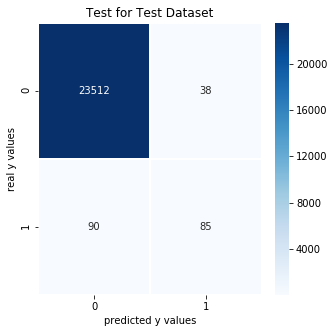

precision_score:  0.6910569105691057
recall_score:  0.4857142857142857
f1_score:  0.5704697986577181


In [795]:
from sklearn.metrics import confusion_matrix
cm_lrc = confusion_matrix(y_test,y_pred)
# print("y_test_01 == 1 :" + str(len(y_test_01[y_test_01==1]))) # 29

# cm visualization
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lrc,annot = True,linewidths=0.5,cmap=plt.cm.Blues,fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.show()

from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test,y_pred))
print("recall_score: ", recall_score(y_test,y_pred))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test,y_pred))
# It seems that the model didn't produce very good accuracy due to the unbalanced target variable. 
# the recall of 1 seems too high compared to the precision
# f1_score is noy that accurate

# precision_score:  0.1407907425265188
#recall_score:  0.8342857142857143
# f1_score:  0.2409240924092409

In [780]:
accuracy = sum(y_pred == y_test)/len(y_test)
error = 1 - accuracy
print("The predictive accuracy is: ", round(accuracy, 2))
print("The classification error is: ", round(error, 2))

# Confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Predict 0', 'Predict 1'], index = ['Actual 0', 'Actual 1'])
print("The Confusion matrix: \n", cnf_matrix)
#The predictive accuracy is:  0.99
#The classification error is:  0.01
#The Confusion matrix: 
#           Predict 0  Predict 1
#Actual 0      23505         45
#Actual 1         84         91

The predictive accuracy is:  0.99
The classification error is:  0.01
The Confusion matrix: 
           Predict 0  Predict 1
Actual 0      23505         45
Actual 1         84         91


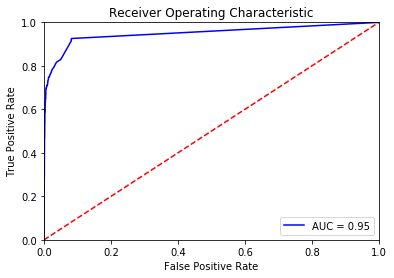

In [782]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pro)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# the auc seems to be very accurate

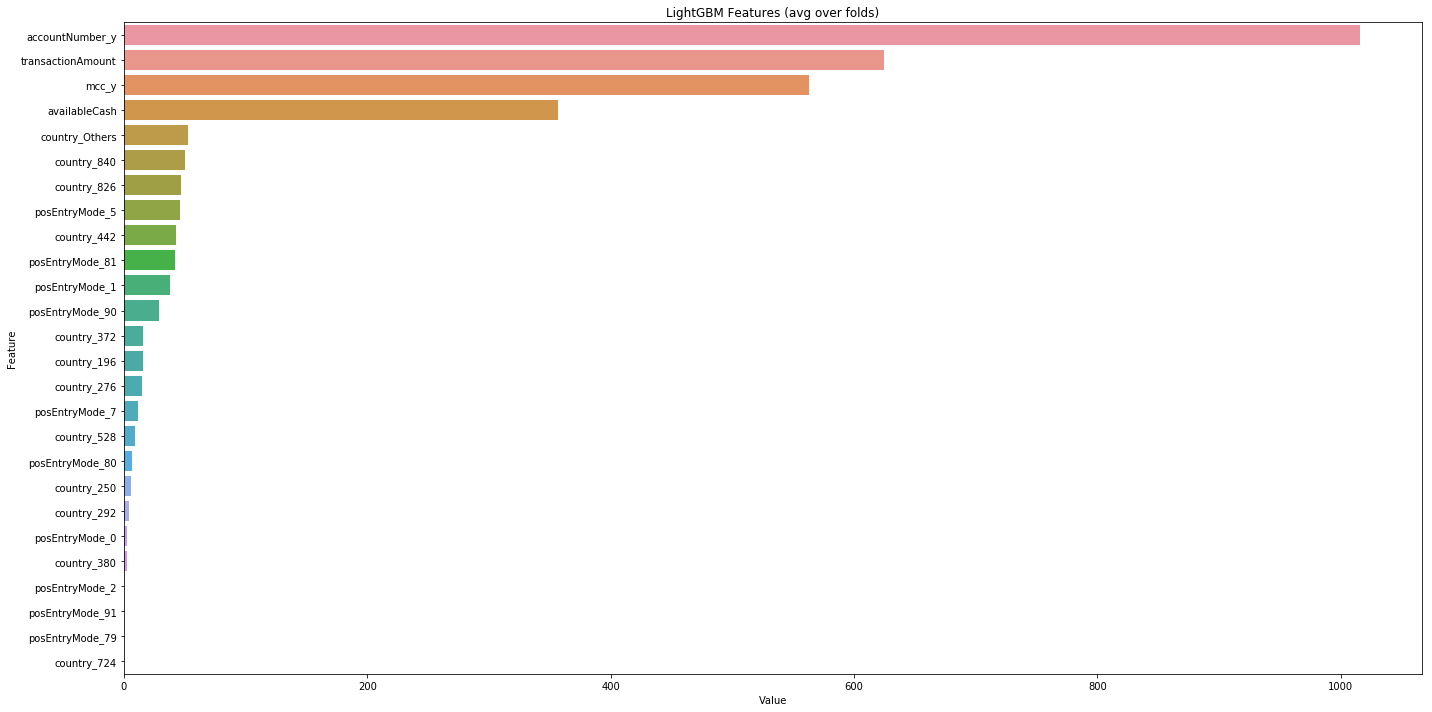

<Figure size 432x288 with 0 Axes>

In [784]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model1.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

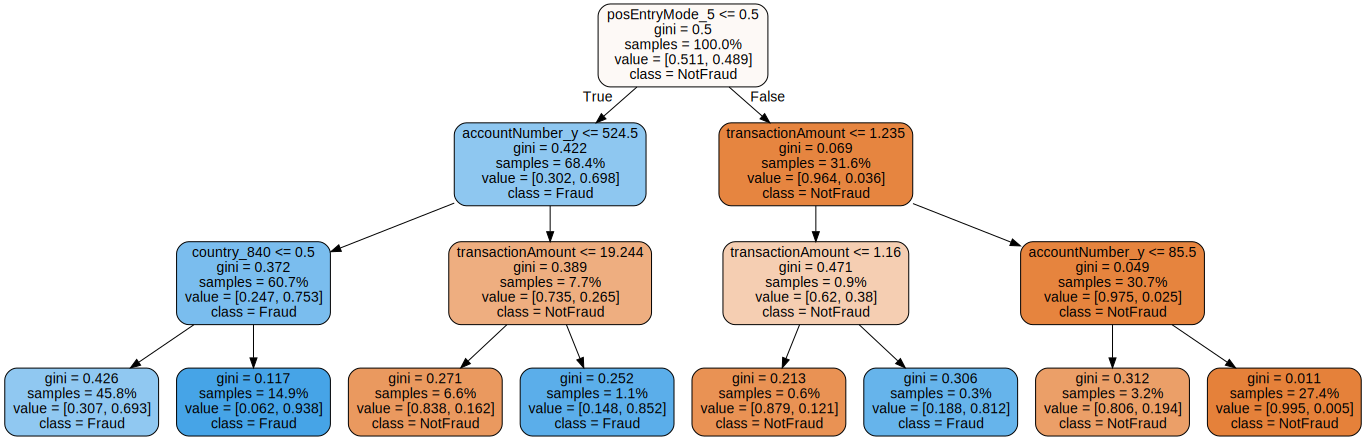

In [797]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(X_train,y_train)
new = export_graphviz(dt,feature_names=X_train.columns,class_names=['NotFraud','Fraud'],out_file=None,
                proportion=True,leaves_parallel=True,filled=True,rounded=True)
graph = graphviz.Source(new)
graph

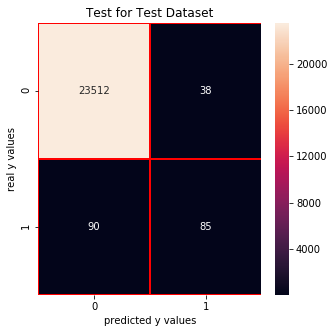

precision_score:  0.6910569105691057
recall_score:  0.4857142857142857
f1_score:  0.5704697986577181


In [791]:
# search for optimal parameter 
from sklearn.model_selection import GridSearchCV

# base models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# meta-models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
rf_par = {'criterion':['gini','entropy']}
rf = GridSearchCV(estimator= RandomForestClassifier(n_estimators=100),
                  param_grid=rf_par,
                  scoring='accuracy',
                  n_jobs = -1,
                  cv = 5)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred1 = rf.predict_proba(X_test)
y_pro = y_pred1[:,1]
from sklearn.metrics import confusion_matrix
cm_lrc = confusion_matrix(y_test,y_pred)


# cm visualization
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lrc,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.show()

from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test,y_pred))
print("recall_score: ", recall_score(y_test,y_pred))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test,y_pred))


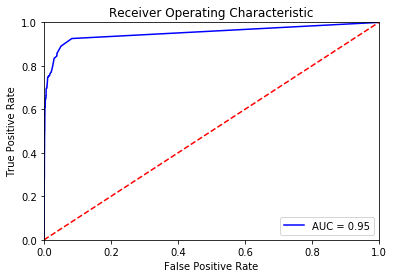

In [792]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pro)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# the auc seems to be very accurate

In [786]:
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV 
gslr = GridSearchCV(estimator=LogisticRegression(random_state=0),
                  param_grid=[{'C': [0.01, 0.1 ,1 ,10 ,100],
                             'penalty':['l1','l2']}],
                  scoring='accuracy',
                  cv=10)
gslr_fit = gslr.fit(X_train, y_train)
y_pred = gslr_fit.predict(X_test)
y_pred1 = gslr_fit.predict_proba(X_test)
y_pro = y_pred1[:,1]

## best parameter
print(gslr.best_params_)
from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test,y_pred))
print("recall_score: ", recall_score(y_test,y_pred))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test,y_pred))
accuracy = sum(y_pred == y_test)/len(y_test)
error = 1 - accuracy
print("The predictive accuracy is: ", round(accuracy, 2))
print("The classification error is: ", round(error, 2))

# Confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Predict 0', 'Predict 1'], index = ['Actual 0', 'Actual 1'])
print("The Confusion matrix: \n", cnf_matrix)


{'C': 10, 'penalty': 'l1'}
precision_score:  0.0310122878876536
recall_score:  0.9085714285714286
f1_score:  0.05997736703130894
The predictive accuracy is:  0.79
The classification error is:  0.21
The Confusion matrix: 
           Predict 0  Predict 1
Actual 0      18582       4968
Actual 1         16        159
